In [ ]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
from h5py import File

from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d

import candel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

with File("/Users/rstiskalek/Projects/CANDEL/results/SH0ES/Cepheid_distances_no_redshift_r2_mu.hdf5", 'r') as f:
    samples = {key: f["samples"][key][...] for key in f["samples"].keys()}

2025-06-24 15:30:54 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-24 15:30:54 indices of zero width: [44]
2025-06-24 15:30:54 found zero-width prior at index 44. Setting it to 0.


In [ ]:
RA = data["RA_host"]
dec = data["dec_host"]
mu_host = samples["mu_host"]

# Assume that H0 ~ 67.4 km/s/Mpc to convert mu_host to distance in Mpc / h
h = 0.674
cosmo = FlatLambdaCDM(H0=h * 100, Om0=0.3153)
zrange = np.linspace(1e-6, 0.1, 10_000)
r_range = cosmo.comoving_distance(zrange).value
mu_range = cosmo.distmod(zrange).value

mu2r = interp1d(mu_range, r_range, kind="cubic")
r_host = mu2r(mu_host)

# Convert to comoving distance Mpc / h
r_host_mean = np.mean(r_host, axis=0) * h

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12610/2705523137.py:13: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12610/2705523137.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


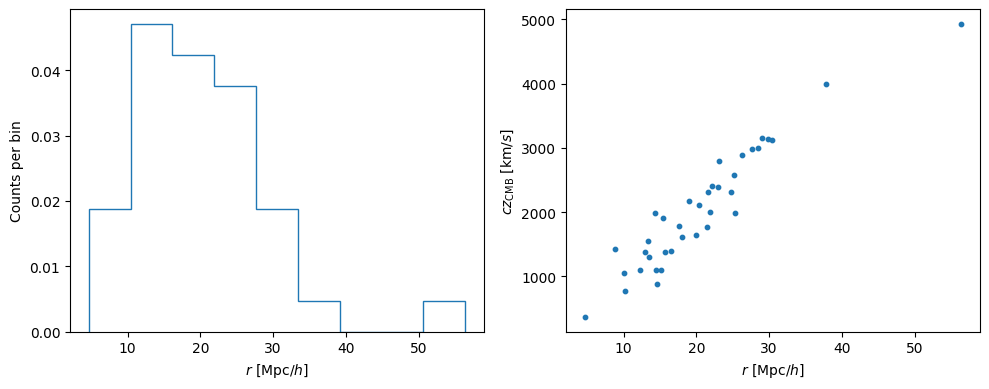

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: Histogram
axes[0].hist(r_host_mean, bins="auto", density=True, histtype='step', label="Cepheid distances")
axes[0].set_xlabel(r"$r~[\mathrm{Mpc}/h]$")
axes[0].set_ylabel("Counts per bin")

# Right: Scatter plot
axes[1].scatter(r_host_mean, data["czcmb_cepheid_host"], s=10)
axes[1].set_xlabel(r"$r~[\mathrm{Mpc}/h]$")
axes[1].set_ylabel(r"$cz_{\rm CMB}~[\mathrm{km}/s]$")

fig.tight_layout()
fig.savefig("/Users/rstiskalek/Downloads/SH0ES_hosts.png", dpi=450)
fig.show()


In [ ]:
k, Pk = candel.cosmo.get_Pk_CAMB()
dDdtau = candel.cosmo.compute_dD_dtau()

print(f"dDdtau = {dDdtau}")

C = candel.cosmo.compute_covariance_matrix(r_host_mean, RA, dec, k, Pk, dDdtau, n_jobs=10)

  0%|          | 0/703 [00:00<?, ?it/s]/Users/rstiskalek/Projects/CANDEL/venv_candel/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 703/703 [01:15<00:00,  9.33it/s]


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12610/2255041822.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


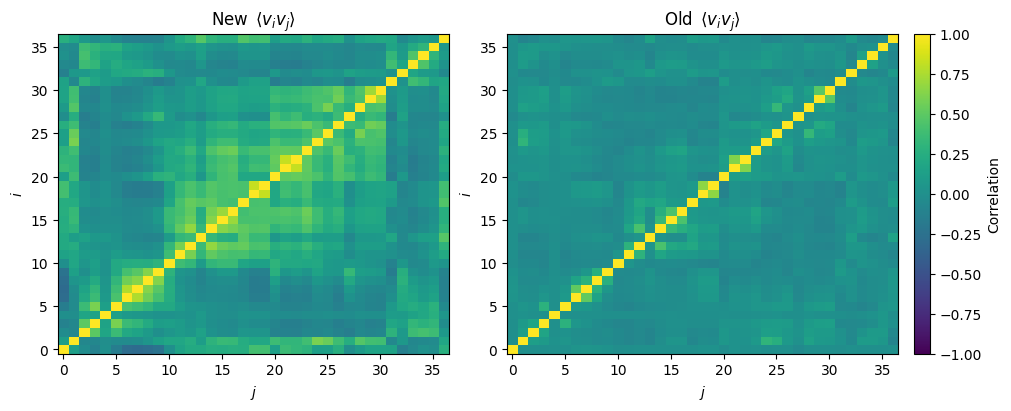

In [ ]:
Cold = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PV_covmat_cepheid_hosts_fiducial_WRONG_OLD.npy")


# Convert covariance matrices to correlation matrices
def covariance_to_correlation(C):
    std = np.sqrt(np.diag(C))
    return C / np.outer(std, std)

Corr = covariance_to_correlation(C)
Corr_old = covariance_to_correlation(Cold)

# Plot side-by-side with shared colorbar
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

vmin, vmax = -1, 1

im0 = axs[0].imshow(Corr, origin='lower', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title(r"New $\,\langle v_{i} v_{j} \rangle$")
axs[0].set_xlabel(r"$j$")
axs[0].set_ylabel(r"$i$")

im1 = axs[1].imshow(Corr_old, origin='lower', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title(r"Old $\,\langle v_{i} v_{j} \rangle$")
axs[1].set_xlabel(r"$j$")
axs[1].set_ylabel(r"$i$")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label=r"Correlation")


fig.savefig("/Users/rstiskalek/Downloads/SH0ES_covariance_comparison.png", dpi=450)
fig.show()


In [22]:
# import pecvelcov

# fname_Pk = "/Users/rstiskalek/Projects/PecVelCov.jl/data/pk_fiducial.npy"
# covmat_brute = pecvelcov.CovmatBrute(fname_Pk)
# C = covmat_brute(r, theta, phi)
# print("Finished! Computed the covariance matrix to be:")
# print(C)

In [12]:
filename_out = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PV_covmat_cepheid_hosts_fiducial.npy"
np.save(filename_out, C)

### Plot a correlation matrix

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12610/166210646.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


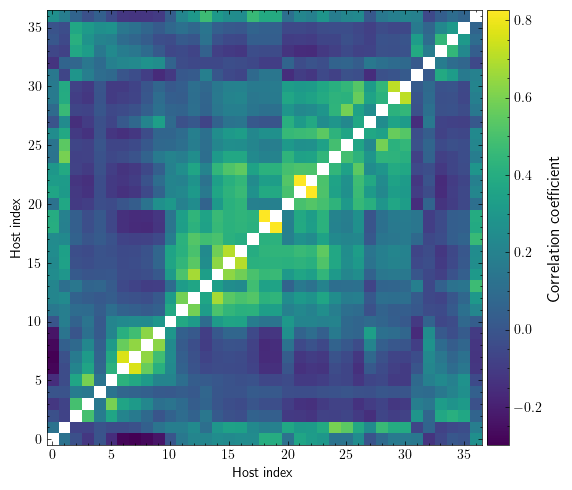

Exception ignored in: <function ResourceTracker.__del__ at 0x107218900>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x119828900>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

In [23]:
# Convert to correlation matrix
D = np.sqrt(np.diag(C))
corr = C / np.outer(D, D)
corr[np.isnan(corr)] = 0.0

# Exclude diagonal
np.fill_diagonal(corr, np.nan)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr, cmap="viridis", origin="lower", )
    
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("Correlation coefficient", fontsize=12)
    
    ax.set_xlabel("Host index",)
    ax.set_ylabel("Host index",)
    ax.tick_params(axis='both',)
    
    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/pecvelcov_correlation_matrix.pdf", bbox_inches='tight', dpi=400)
    
    fig.show()